In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = pd.read_csv('data_cleaned.csv')
print(data.shape)
data.head()

(337144, 9)


,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic,positive,clean_text
0,haha you guys are a bunch of losers.,0,1,0,0,0,1,0,haha guys bunch losers
1,ur a sh*tty comment.,0,0,1,0,0,1,0,tty comment
2,It's ridiculous that these guys are being call...,0,1,0,0,0,1,0,ridiculous guys called protesters armed threat...
3,Yet call out all Muslims for the acts of a few...,1,1,0,0,0,1,0,muslims acts pilloried okay smear entire relig...
4,This bitch is nuts. Who would read a book by a...,0,1,1,0,0,1,0,bitch nuts read book woman


In [3]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

(336740, 9)


In [4]:
labels= ['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
vectorizer = TfidfVectorizer(sublinear_tf=True)

vects = vectorizer.fit_transform(data['clean_text'])

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline as Pline

pipeline = Pline([('o', SMOTE(sampling_strategy=1.00)), ('u', RandomUnderSampler(sampling_strategy=1.00))])

Using TensorFlow backend.


In [8]:
from utils.ml import train_model

In [9]:
from sklearn.linear_model import LogisticRegression

X shape (401418, 259211) 
Y shape (401418,)
Mean Score 0.981 +- 0.0005
Mean Accuracy 0.9392 +- 0.0011


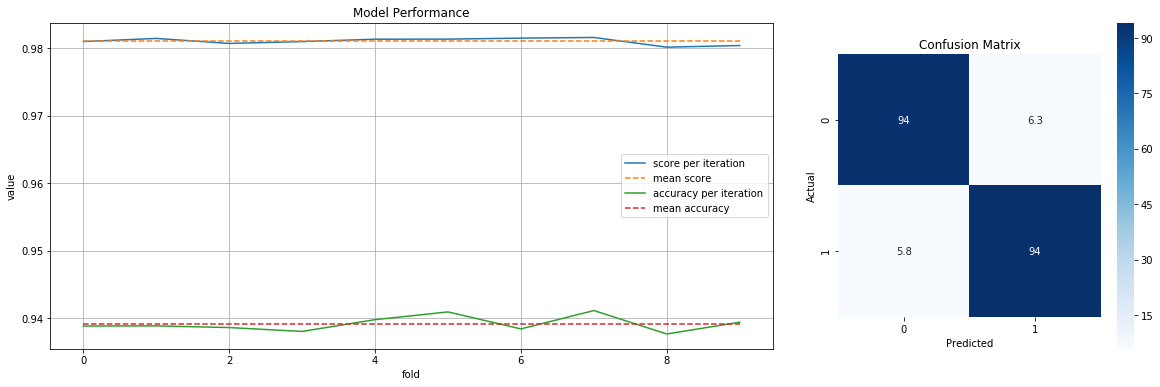

In [10]:
col = 'positive'
y = data[col].values
X, y = pipeline.fit_resample(vects, y)

print('X shape', X.shape, '\nY shape', y.shape)

model = LogisticRegression(solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr0_performance, lr0_cm, lr0_model = train_model(model, X, y)
print('Mean Score', round(np.mean(lr0_performance['score']), 4), '+-', round(np.std(lr0_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr0_performance['accuracy']), 4), '+-', round(np.std(lr0_performance['accuracy']), 4))

del X, y

X shape (653304, 259211) 
Y shape (653304,)
Mean Score 0.9915 +- 0.0004
Mean Accuracy 0.9626 +- 0.0006


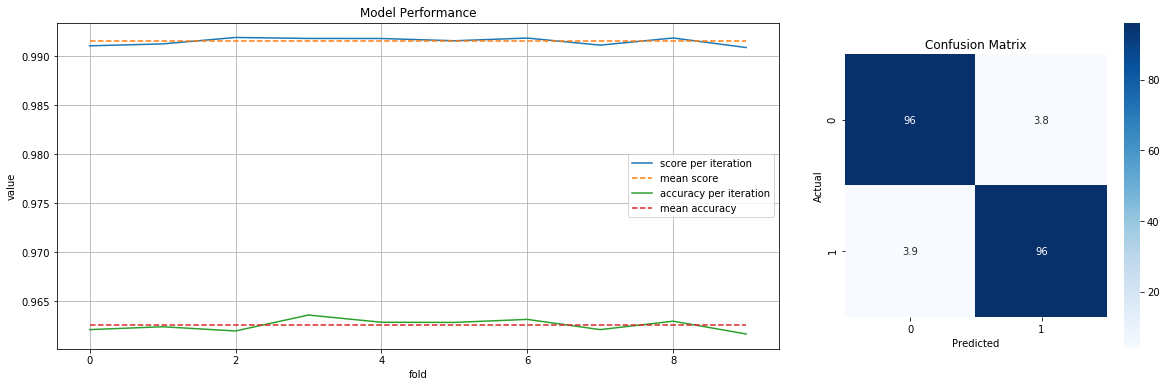

In [11]:
col = 'identity_hate'
y = data[col].values
X, y = pipeline.fit_resample(vects, y)

print('X shape', X.shape, '\nY shape', y.shape)

model = LogisticRegression(solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr1_performance, lr1_cm, lr1_model = train_model(model, X, y)
print('Mean Score', round(np.mean(lr1_performance['score']), 4), '+-', round(np.std(lr1_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr1_performance['accuracy']), 4), '+-', round(np.std(lr1_performance['accuracy']), 4))

del X, y

X shape (484624, 259211) 
Y shape (484624,)
Mean Score 0.9702 +- 0.0005
Mean Accuracy 0.9182 +- 0.0012


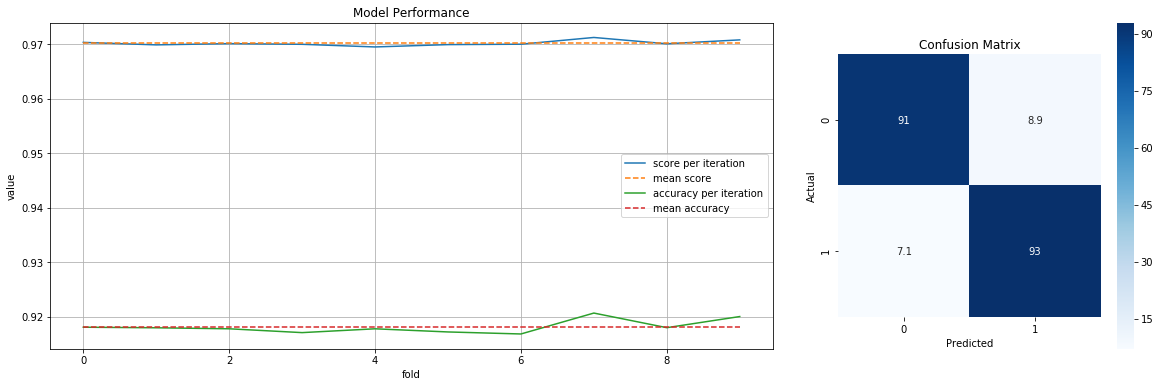

In [12]:
col = 'insult'
y = data[col].values
X, y = pipeline.fit_resample(vects, y)

print('X shape', X.shape, '\nY shape', y.shape)

model = LogisticRegression(solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr2_performance, lr2_cm, lr2_model = train_model(model, X, y)
print('Mean Score', round(np.mean(lr2_performance['score']), 4), '+-', round(np.std(lr2_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr2_performance['accuracy']), 4), '+-', round(np.std(lr2_performance['accuracy']), 4))

del X, y

X shape (633232, 259211) 
Y shape (633232,)
Mean Score 0.9899 +- 0.0003
Mean Accuracy 0.9458 +- 0.0007


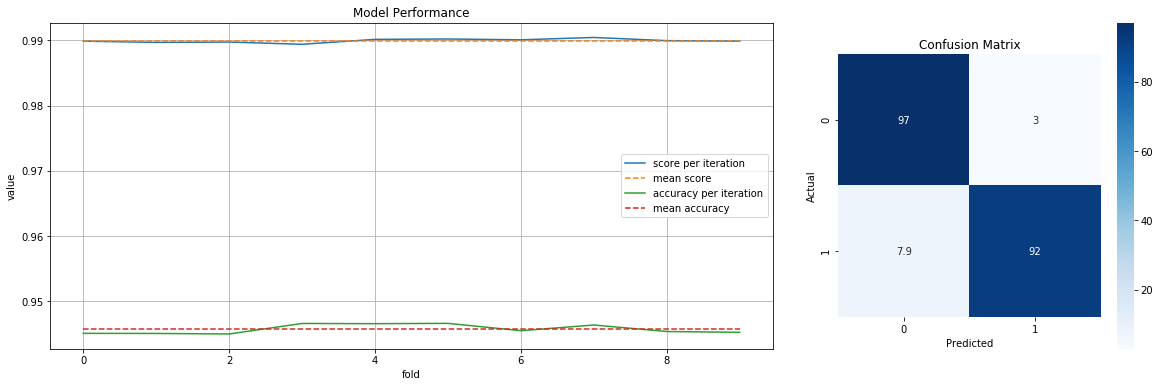

In [13]:
col = 'obscene'
y = data[col].values
X, y = pipeline.fit_resample(vects, y)

print('X shape', X.shape, '\nY shape', y.shape)

model = LogisticRegression(solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr3_performance, lr3_cm, lr3_model = train_model(model, X, y)
print('Mean Score', round(np.mean(lr3_performance['score']), 4), '+-', round(np.std(lr3_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr3_performance['accuracy']), 4), '+-', round(np.std(lr3_performance['accuracy']), 4))

del X, y

X shape (669542, 259211) 
Y shape (669542,)
Mean Score 0.9965 +- 0.0002
Mean Accuracy 0.9878 +- 0.0007


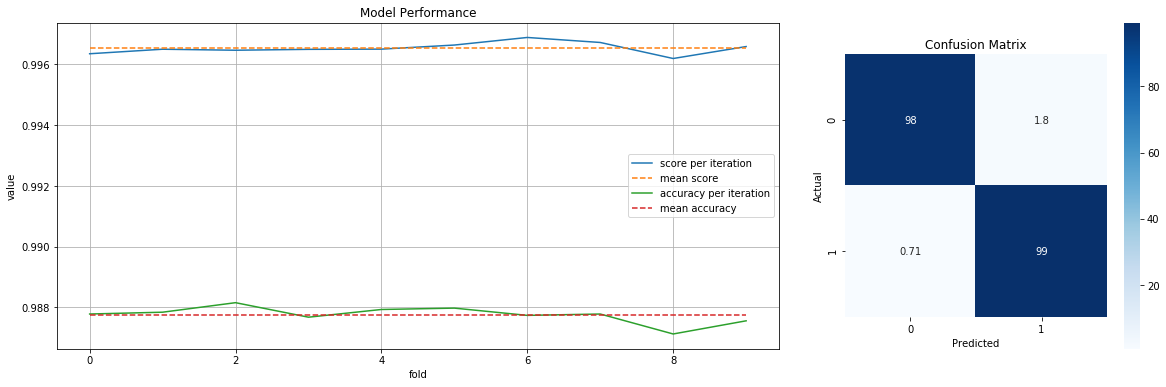

In [14]:
col = 'severe_toxic'
y = data[col].values
X, y = pipeline.fit_resample(vects, y)

print('X shape', X.shape, '\nY shape', y.shape)

model = LogisticRegression(solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr4_performance, lr4_cm, lr4_model = train_model(model, X, y)
print('Mean Score', round(np.mean(lr4_performance['score']), 4), '+-', round(np.std(lr4_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr4_performance['accuracy']), 4), '+-', round(np.std(lr3_performance['accuracy']), 4))

del X, y

X shape (666266, 259211) 
Y shape (666266,)
Mean Score 0.9958 +- 0.0002
Mean Accuracy 0.9784 +- 0.0005


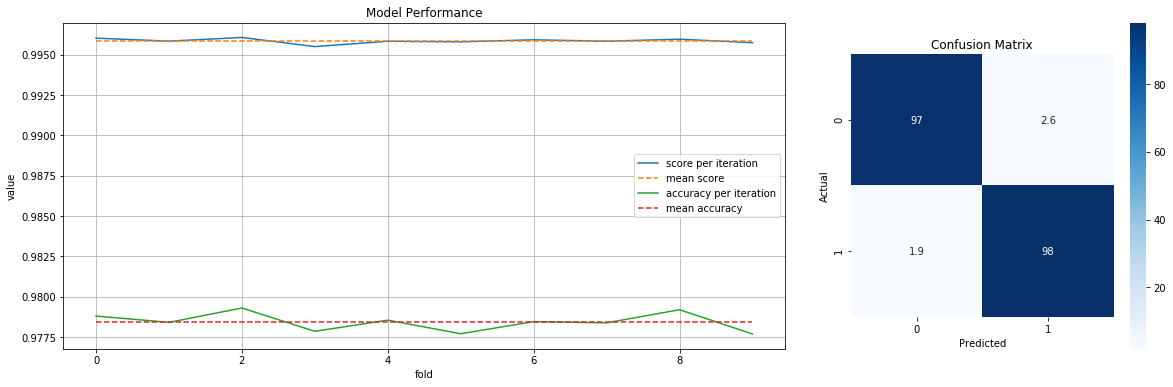

In [15]:
col = 'threat'
y = data[col].values
X, y = pipeline.fit_resample(vects, y)

print('X shape', X.shape, '\nY shape', y.shape)

model = LogisticRegression(solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr5_performance, lr5_cm, lr5_model = train_model(model, X, y)
print('Mean Score', round(np.mean(lr5_performance['score']), 4), '+-', round(np.std(lr5_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr5_performance['accuracy']), 4), '+-', round(np.std(lr5_performance['accuracy']), 4))

del X, y

X shape (408866, 259211) 
Y shape (408866,)
Mean Score 0.9769 +- 0.0005
Mean Accuracy 0.935 +- 0.0012


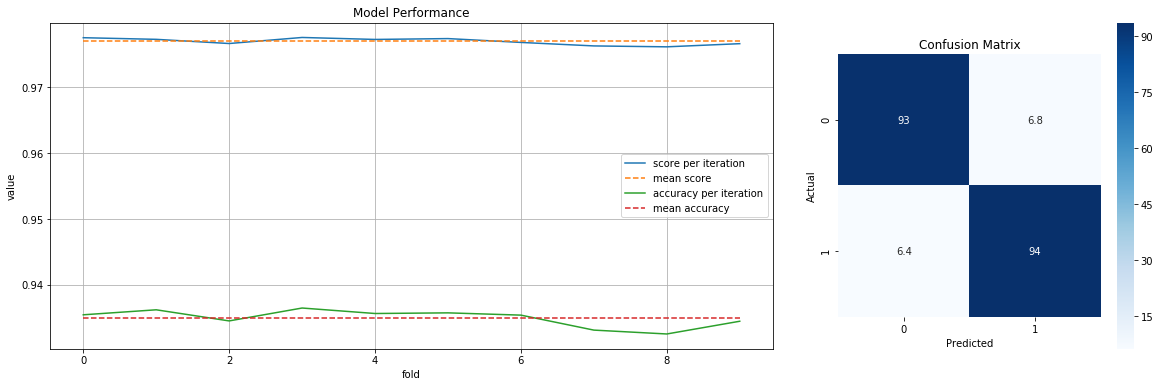

In [16]:
col = 'toxic'
y = data[col].values
X, y = pipeline.fit_resample(vects, y)

print('X shape', X.shape, '\nY shape', y.shape)

model = LogisticRegression(solver='lbfgs', max_iter=1_00_000, random_state=101, warm_start=True, C=0.1)
lr6_performance, lr6_cm, lr6_model = train_model(model, X, y)
print('Mean Score', round(np.mean(lr6_performance['score']), 4), '+-', round(np.std(lr6_performance['score']), 4))
print('Mean Accuracy', round(np.mean(lr6_performance['accuracy']), 4), '+-', round(np.std(lr6_performance['accuracy']), 4))

del X, y

In [17]:
import pickle

In [19]:
pickle.dump([lr0_model, lr1_model, lr2_model, lr3_model, lr4_model, lr5_model, lr6_model], open('SMOTE.pkl', 'wb'))